# Imports

In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal, trim_mean
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, RocCurveDisplay, roc_curve, auc
from imblearn.over_sampling import KMeansSMOTE, SMOTE
from imblearn.under_sampling import ClusterCentroids

In [413]:
def plot_ROC(Y_hats, Y_test):
    roc_arr = []
    for i in range(len(Y_hats)):
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_hats[i]).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        roc_arr.append([fpr, tpr])

    roc_arr = np.array(roc_arr)
    sorted_indices = np.argsort(roc_arr[:, 0])
    roc_arr = roc_arr[sorted_indices]

    plt.plot(roc_arr[:, 0], roc_arr[:, 1])
    plt.xlim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylim([0, 1])
    plt.ylabel("True Positive Rate")
    plt.show()
    return roc_arr

# Task 1

In [429]:
df = pd.read_csv("Assignment Data/bankPortfolios.csv", names=["construction loans", "farm_secured", "res_secured_minor", "res_secured_major", "asset_secured", "argri_loans", "commercial_loans", "individual loans", "other loans", "political obligations", "illiquid securities","liquid securities", "fixed assets", "cash", "debt", "default"])

X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[:-1]], df["default"], test_size=0.2)
# X_train_re, Y_train_re = SMOTE(sampling_strategy=0.5).fit_resample(X_train, Y_train)
X_train_re, Y_train_re = KMeansSMOTE(k_neighbors=5, kmeans_estimator=50, cluster_balance_threshold=0.4).fit_resample(X_train, Y_train)
X_train_cc, Y_train_cc = ClusterCentroids().fit_resample(X_train, Y_train)

def test(Y_hat, Y_true):
    return sum(Y_hat == Y_true)/len(Y_true)

/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Model Definitions

### Gaussian Discriminant Model
Should sample the data many times to get a non-parametric distribution of results.

In [415]:
def Gaussian_Discrim(X_train, Y_train, X_test, theta):
    priors = (1 - Y_train.mean(), Y_train.mean())
    class_0 = X_train[Y_train == 0]
    class_1 = X_train[Y_train == 1]

    covariances = [class_0.cov(), class_1.cov()]
    means = [class_0.mean(), class_1.mean()]

    normals = [multivariate_normal(means[0], covariances[0]), multivariate_normal(means[1], covariances[1])]

    def calc_prob(item, priors, normals, Y):
        return priors[Y]*normals[Y].pdf(item)/(priors[0]*normals[0].pdf(item) + priors[1]*normals[1].pdf(item))

    results = []

    for i in range(len(X_test)):
        Y_0 = calc_prob(X_test.iloc[i], priors, normals, Y=0)
        Y_1 = calc_prob(X_test.iloc[i], priors, normals, Y=1)
        if theta:
            results.append([Y_0, Y_1])
        else:
            if Y_1 > Y_0:
                results.append(1)
            else:
                results.append(0)

    Y_hat = np.array(results)
    Y_hat = np.nan_to_num(Y_hat, nan=1)
    return Y_hat


### Logistic Regression
Use regulariser?

In [416]:
def logistic_reg(X_train, Y_train, X_test, theta, penalty):
    model = LogisticRegression(penalty=penalty)
    model.fit(X_train, Y_train)
    if theta:
        Y_hat_p = model.predict_proba(X_test)
        return Y_hat_p
    else:
        Y_hat = model.predict(X_test)
    return Y_hat
#print((Y_hat == Y_test).sum()/len(Y_test))

### Neural Network

In [417]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [418]:
def NN_classifier(X_train, Y_train, X_test, arch, theta):
    # Scaling the data
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Defining the neural network model
    model = MLPClassifier(hidden_layer_sizes=arch, activation='relu', random_state=42, max_iter=1000)
    res = model.fit(X_train_scaled, Y_train)

    if theta:
        Y_hat_p = model.predict_proba(X_test_scaled)
        return Y_hat_p
    else:
        Y_hat = model.predict(X_test_scaled)

    return Y_hat

### Trees

In [419]:
from xgboost import XGBClassifier

In [420]:
def XGB_model(X_train, Y_train, X_test, arch, theta):
    model = XGBClassifier(n_estimators=arch[0], max_depth=arch[1], learning_rate=arch[2])
    res = model.fit(X_train, Y_train)

    if theta:
        Y_hat_p = model.predict_proba(X_test)
        return Y_hat_p
    else:
        Y_hat = model.predict(X_test)

    return Y_hat


## Cross-Validation

In [421]:
from sklearn.model_selection import cross_validate
from itertools import product
measures = ["accuracy", "recall"]

penalties = ["l2", None]
results_log = []

X_data, Y_data = X_train_re, Y_train_re

for reg in penalties:
    model = LogisticRegression(penalty=reg)
    score = cross_validate(model, X_data, Y_data, cv=5, scoring=measures)
    results_log.append(score)

# Scaling the data
scaler = StandardScaler().fit(X_data)
X_train_scaled = scaler.transform(X_data)

hidden_layers = [(16,32), (8,16), (16,16), (32,16)]
results_nn = []

for spec in hidden_layers:
    model = MLPClassifier(hidden_layer_sizes=spec, activation='relu', random_state=42, max_iter=1000)
    score = cross_validate(model, X_train_scaled, Y_data, cv=5, scoring=measures)
    results_nn.append(score)


estimators = range(7,15)
depth = range(7,15)
alpha = [0.5,1,1.5]
param_combos = [element for element in product(estimators, depth, alpha)]
results_tree = []

for params in param_combos:
    model = XGBClassifier(n_estimators=params[0], max_depth=params[1], learning_rate=params[2])
    score = cross_validate(model, X_data, Y_data, cv=5, scoring=measures)
    results_tree.append(score)

NameError: name 'X_train_re' is not defined

$$\text{Combined Performance} = \sum_{i=1}^nw_i(\text{Metric}_i^{\text{mean}} - \alpha \text{Metric}_i^\text{std})$$

In [206]:
specs = [[penalties, results_log], [hidden_layers, results_nn], [param_combos, results_tree]]
optimal_specs = []

def comb_perf(data, weights, alpha):
    res = []
    for i in range(len(data)):
        acc = (data[i]["test_accuracy"].mean() - alpha*data[i]["test_accuracy"].std())
        recall = (data[i]["test_recall"].mean() - alpha*data[i]["test_recall"].std())
        res.append(weights[0]*acc + weights[1]*recall)
    return res

for spec in specs:
    idx = comb_perf(spec[1], weights=[0.3,0.7], alpha=0.1)
    optimal_specs.append([spec[0][np.argmax(idx)], np.max(idx)])

In [422]:
optimal_specs_dict = {"Normal": {"log": None, "NN": (8,16), "XGB": (9, 13, 1.5)}, "KM-SMOTE": {"log": "l2", "NN": (8,16), "XGB": (10, 7, 1)}, "CC": {"log": "l2", "NN": (8,16), "XGB": (7, 12, 0.5)}}

## ROC Curve Creation

Getting FPR and TPR for the Models across Sampling Data

In [423]:
X_idx = np.random.choice(X_train.index, len(X_train))
X_train.loc[X_idx].drop_duplicates()

,construction loans,farm_secured,res_secured_minor,res_secured_major,asset_secured,argri_loans,commercial_loans,individual loans,other loans,political obligations,illiquid securities,liquid securities,fixed assets,cash,debt
1213,11410.0,1168.0,10617.0,4693.00,18904.0,318.0,71978.0,7472.0,263.000,4200.70,42046.0,88738.0,2055.00,18639.0,256520.0
3700,1352.0,605.0,40283.0,405.00,14611.0,5723.0,10969.0,9740.0,70.000,2860.00,190.0,17166.0,3184.00,23090.0,118720.0
575,1317700.0,3340.0,1087100.0,44366.00,687860.0,337.0,311730.0,50173.0,10362.000,4124.00,277960.0,859160.0,108710.00,91270.0,4354900.0
1331,578.0,136.0,47128.0,641.00,7903.0,4311.1,1305.0,458.0,100.000,42.00,5374.9,62326.0,1390.00,3261.0,122850.0
5848,388.0,10697.0,28645.0,663.97,16294.0,9303.0,10316.0,7275.0,65.000,432.00,2740.0,3070.0,1167.00,3242.0,81689.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4663,1219.4,3870.7,2806.3,172.32,1026.3,9903.1,3156.4,2424.5,42.535,130.88,1449.5,7916.0,435.17,1563.0,32140.0
6068,24575.0,827.0,28359.0,492.00,19194.0,31.0,24022.0,3157.0,1886.200,3370.80,18666.0,4925.0,7634.00,6591.0,129810.0
6523,28922.0,58243.0,68921.0,2583.50,73443.0,7959.0,36765.0,33132.0,595.990,1065.10,10661.0,38597.0,15103.00,8800.0,354570.0
3689,12975.0,6061.0,53345.0,61.00,37888.0,1562.0,4133.0,7479.0,879.000,105.00,13933.0,29978.0,6592.00,3889.0,163140.0


In [424]:
data_train_re = []
while len(data_train_re) < 26:
    try:
        X_train_re, Y_train_re = KMeansSMOTE(k_neighbors=5, kmeans_estimator=100, cluster_balance_threshold=0.4).fit_resample(X_train, Y_train)
        data_train_re.append([X_train_re, Y_train_re])
    except:
        pass

/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1934: F

In [431]:
Y_hats_log, Y_hats_NN, Y_hats_XGB = [[], [], []], [[], [], []], [[], [], []]

for i in range(25):
    X_idx = np.random.choice(X_train.index, len(X_train))
    X_train_boot, Y_train_boot = X_train.loc[X_idx], Y_train.loc[X_idx]
    X_train_re, Y_train_re = data_train_re[i]
    X_train_cc, Y_train_cc = ClusterCentroids().fit_resample(X_train, Y_train)

    sampling_data = [[X_train_boot, Y_train_boot, "Normal"], [X_train_re, Y_train_re, "KM-SMOTE"], [X_train_cc, Y_train_cc, "CC"]]

    for idx, data_type in enumerate(sampling_data):
        X_data, Y_data, samp_method = data_type
        pen, arch_NN, xgb = optimal_specs_dict[samp_method].values()

        Y_hats_log[idx].append(logistic_reg(X_data, Y_data, X_test, theta=True, penalty=pen))
        Y_hats_NN[idx].append(NN_classifier(X_data, Y_data, X_test, arch_NN, theta=True))
        Y_hats_XGB[idx].append(XGB_model(X_data, Y_data, X_test, xgb, theta=True))

/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adamkeys/opt/anaconda3/envs/quant/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (statu

In [432]:
p_data = [Y_hats_log, Y_hats_NN, Y_hats_XGB]
labels = ["Logistic", "Neural Network", "XGBoost"]

roc_BTS = [[roc_curve(Y_test, p_data[j][0][i][:,1]) for i in range(25)] for j in range(3)]
roc_BTS_log_XY = [np.vstack([roc_BTS[0][i][0], roc_BTS[0][i][1]]).T for i in range(25)]
roc_BTS_NN_XY = [np.vstack([roc_BTS[1][i][0], roc_BTS[1][i][1]]).T for i in range(25)]
roc_BTS_XGB_XY = [np.vstack([roc_BTS[2][i][0], roc_BTS[2][i][1]]).T for i in range(25)]

roc_KMSO = [[roc_curve(Y_test, p_data[j][1][i][:,1]) for i in range(25)] for j in range(3)]
roc_KMSO_log_XY = [np.vstack([roc_KMSO[0][i][0], roc_KMSO[0][i][1]]).T for i in range(25)]
roc_KMSO_NN_XY = [np.vstack([roc_KMSO[1][i][0], roc_KMSO[1][i][1]]).T for i in range(25)]
roc_KMSO_XGB_XY = [np.vstack([roc_KMSO[2][i][0], roc_KMSO[2][i][1]]).T for i in range(25)]

roc_CC = [[roc_curve(Y_test, p_data[j][2][i][:,1]) for i in range(25)] for j in range(3)]
roc_CC_log_XY = [np.vstack([roc_CC[0][i][0], roc_CC[0][i][1]]).T for i in range(25)]
roc_CC_NN_XY = [np.vstack([roc_CC[1][i][0], roc_CC[1][i][1]]).T for i in range(25)]
roc_CC_XGB_XY = [np.vstack([roc_CC[2][i][0], roc_CC[2][i][1]]).T for i in range(25)]

In [433]:
def interp_ROC(XY):
    x = np.linspace(0, 1, num=100)

    interpolated_arrays = []
    for arr in XY:
        interpolator = interp1d(arr[:, 0], arr[:, 1], kind='linear', fill_value='interpolate')
        interpolated_Y = interpolator(x)
        interpolated_arrays.append(interpolated_Y)

    # Calculate the mean and standard deviation of the interpolated y-values.
    mean_Y = np.mean(interpolated_arrays, axis=0)
    std_Y = np.std(interpolated_arrays, axis=0)
    mean_Y[0] = 0

    # Calculate 95th percentile confidence interval.
    CI = 2.58 * std_Y / np.sqrt(len(XY))  # Assuming a large enough sample size for the z-value
    return mean_Y, CI

#plt.plot(x, mean_Y, label='Mean Curve')
#plt.fill_between(x, mean_Y - confidence_interval, mean_Y + confidence_interval, color='blue', alpha=0.2, label='95% Confidence Interval')


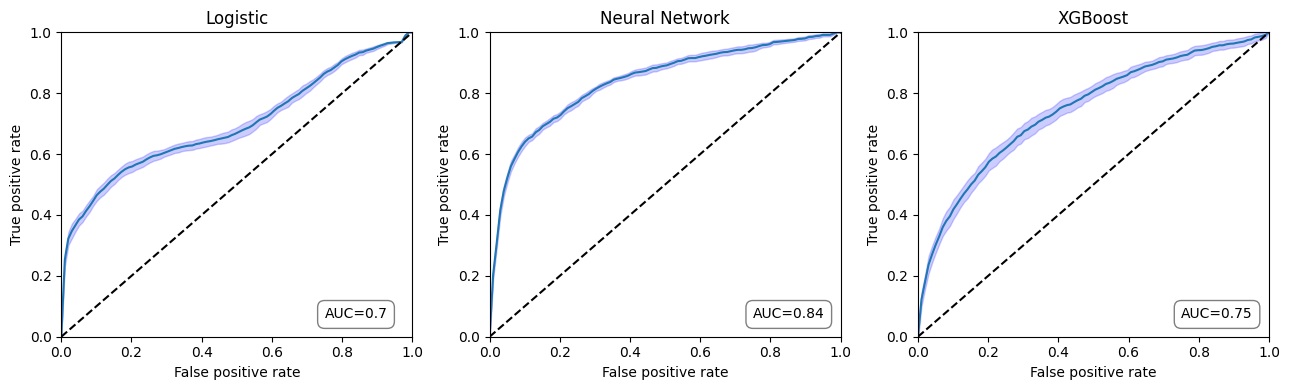

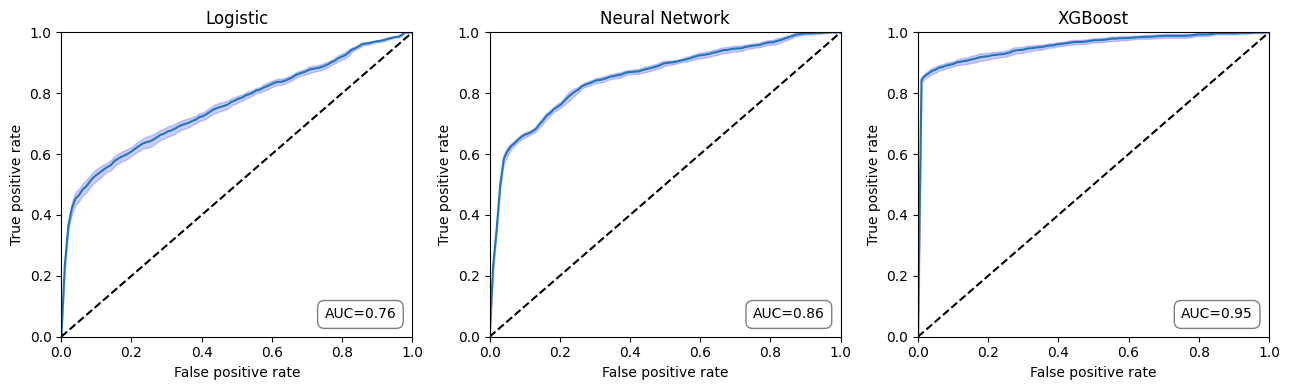

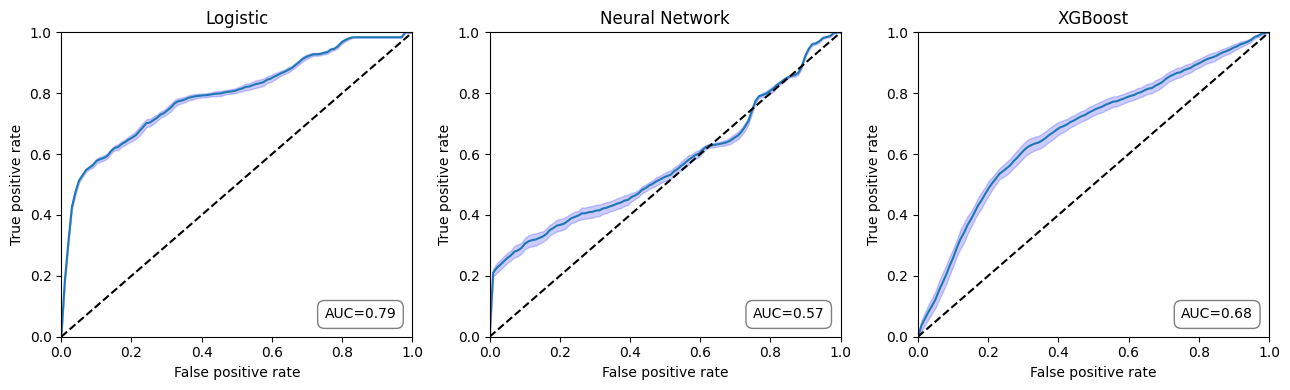

In [447]:
roc_N = [interp_ROC(roc_BTS_log_XY), interp_ROC(roc_BTS_NN_XY), interp_ROC(roc_BTS_XGB_XY)]
roc_KMSO = [interp_ROC(roc_KMSO_log_XY), interp_ROC(roc_KMSO_NN_XY), interp_ROC(roc_KMSO_XGB_XY)]
roc_CC = [interp_ROC(roc_CC_log_XY), interp_ROC(roc_CC_NN_XY), interp_ROC(roc_CC_XGB_XY)]
x = np.linspace(0,1,100)

fig, axes = plt.subplots(1,3, figsize=(13, 4), tight_layout=True)
#fig.suptitle("No Resampling")
auc_N = [auc(x, roc_N[i][0]) for i in range(3)]
for i in range(3):
    axes[i].plot(x, roc_N[i][0], label="Mean Value")
    axes[i].plot(x, x, color="black", linestyle="dashed")
    axes[i].fill_between(x, roc_N[i][0] - roc_N[i][1], roc_N[i][0] + roc_N[i][1], color='blue', alpha=0.2, label='95% C.I.')
    axes[i].set_title(labels[i])
    axes[i].set_xlabel("False positive rate")
    axes[i].set_ylabel("True positive rate")
    axes[i].text(0.75,0.06, f"AUC={round(auc_N[i],2)}", bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    #axes[i].legend()
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([0,1])

plt.savefig("no_resample.png", dpi=200)


fig, axes = plt.subplots(1,3, figsize=(13, 4), tight_layout=True)
#fig.suptitle("K-Means SMOTE")
auc_KMSO = [auc(x, roc_KMSO[i][0]) for i in range(3)]
for i in range(3):
    axes[i].plot(x, roc_KMSO[i][0], label="Mean Value")
    axes[i].plot(x, x, color="black", linestyle="dashed")
    axes[i].fill_between(x, roc_KMSO[i][0] - roc_KMSO[i][1], roc_KMSO[i][0] + roc_KMSO[i][1], color='blue', alpha=0.2, label='95% C.I.')
    axes[i].set_title(labels[i])
    axes[i].set_xlabel("False positive rate")
    axes[i].set_ylabel("True positive rate")
    axes[i].text(0.75,0.06, f"AUC={round(auc_KMSO[i],2)}", bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    #axes[i].legend()
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([0,1])
plt.savefig("kmeans_SMOTE.png", dpi=200)


fig, axes = plt.subplots(1,3, figsize=(13, 4), tight_layout=True)
#fig.suptitle("Central Centroids")
auc_CC = [auc(x, roc_CC[i][0]) for i in range(3)]
for i in range(3):
    axes[i].plot(x, roc_CC[i][0], label="Mean Value")
    axes[i].plot(x, x, color="black", linestyle="dashed")
    axes[i].fill_between(x, roc_CC[i][0] - roc_CC[i][1], roc_CC[i][0] + roc_CC[i][1], color='blue', alpha=0.2, label='95% C.I.')
    axes[i].set_title(labels[i])
    axes[i].set_xlabel("False positive rate")
    axes[i].set_ylabel("True positive rate")
    axes[i].set_xlim([0,1])
    axes[i].set_ylim([0,1])
    axes[i].text(0.75,0.06, f"AUC={round(auc_CC[i],2)}", bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.5'))
    #axes[i].legend()

plt.savefig("central_centroids.png", dpi=200)

# Task 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt.solvers import qp
from sklearn.model_selection import KFold

In [4]:
df = pd.read_csv("Assignment Data/48_Industry_Portfolios_daily.CSV").iloc[:24099]
df["Date"] = pd.to_datetime(df["Unnamed: 0"], format="%Y%m%d")
df.columns = [column.strip() for column in df.columns]
df = df.set_index("Date", drop=True).drop(columns="Unnamed: 0").astype(float)
df = df[df.index > "1969-01-01"].dropna()

test_idx = int(len(df)*0.8)
df_train, df_test = df.iloc[:test_idx], df.iloc[test_idx:]

/var/folders/s0/3xfz71116_d8m7n9p2tc7kzc0000gn/T/ipykernel_9573/621531644.py:1: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,21,22,23,24,25,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Assignment Data/48_Industry_Portfolios_daily.CSV").iloc[:24099]


In [5]:
def min_var(df):
    C = df.cov()
    J = np.linalg.inv(C)
    i = np.ones(len(C)).T

    return J@i/(i.T@J@i)

def calc_var_ret(data, weights):
    w_df = data*weights
    var = w_df.sum(axis=1).var()
    perc_rets = (w_df.sum(axis=1)+100)/100
    total_ret = perc_rets.cumprod()[-1]

    return total_ret, var

# Compute min variance using quadratic programming library.
def min_var_no_shorts(df):
    # Define covariance from data.
    C = matrix(df.cov().to_numpy())
    n = df.shape[1]
    r = matrix(np.zeros((n, 1)))

    # Define constraint matrices.
    A = matrix(np.ones(n)).T
    b = matrix(1.0)
    G = matrix(-np.eye(n))
    h = matrix(np.zeros(n))

    # Solve using qp function.
    sol = qp(C, r, G, h, A, b)['x']
    return [x for x in sol]

In [28]:
def condition_num(df, lam=0):
    C = df.cov() + lam*np.eye(df.shape[1])
    J = np.linalg.inv(C)
    return np.linalg.cond(J, "fro")

In [10]:
# want in and out of sample variance/rets as p/n changes

In [449]:
res = []
res_ns = []
cond_arr = []
p = df_train.shape[1]
space = pd.Series(np.logspace(0, np.log10(len(df_train)-p), 700, dtype=int)).drop_duplicates().to_numpy() + 47

for i in space:
    i_train = df_train[-i:]
    w_star = min_var(i_train)
    w_star_ns = min_var_no_shorts(i_train)
    cond_arr.append([p/len(i_train), condition_num(i_train)])
    res_ns.append([p/len(i_train), *calc_var_ret(i_train, w_star_ns), *calc_var_ret(df_test, w_star_ns)])
    res.append([p/len(i_train), *calc_var_ret(i_train, w_star), *calc_var_ret(df_test, w_star)])

res_df = pd.DataFrame(res, columns=["p/n", "train_ret", "train_var", "test_ret", "test_var"])
res_df_ns = pd.DataFrame(res_ns, columns=["p/n", "train_ret", "train_var", "test_ret", "test_var"])
res_df.set_index("p/n", drop=True, inplace=True)
res_df_ns.set_index("p/n", drop=True, inplace=True)

     pcost       dcost       gap    pres   dres
 0:  1.4275e-01 -7.8252e-01  6e+01  8e+00  8e+00
 1:  2.6703e-01 -5.7986e-01  4e+00  4e-01  4e-01
 2:  5.0392e-01  3.1670e-03  5e-01  7e-17  4e-15
 3:  4.1484e-01  2.8077e-01  1e-01  2e-16  2e-15
 4:  3.5069e-01  3.1698e-01  3e-02  1e-16  1e-15
 5:  3.2933e-01  3.2708e-01  2e-03  2e-16  1e-15
 6:  3.2765e-01  3.2761e-01  4e-05  4e-16  1e-15
 7:  3.2763e-01  3.2763e-01  5e-07  2e-16  1e-15
 8:  3.2763e-01  3.2763e-01  5e-09  3e-17  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.4761e-01 -7.8596e-01  6e+01  8e+00  8e+00
 1:  2.6412e-01 -5.8585e-01  4e+00  4e-01  4e-01
 2:  4.9609e-01 -1.1688e-03  5e-01  2e-16  4e-15
 3:  4.0742e-01  2.7386e-01  1e-01  1e-16  2e-15
 4:  3.4400e-01  3.0998e-01  3e-02  2e-16  1e-15
 5:  3.2258e-01  3.2022e-01  2e-03  7e-17  1e-15
 6:  3.2083e-01  3.2078e-01  4e-05  1e-16  1e-15
 7:  3.2080e-01  3.2080e-01  6e-07  4e-17  1e-15
 8:  3.2080e-01  3.2080e-01  6e-09  2e-16  1e-1

     pcost       dcost       gap    pres   dres
 0:  2.4500e-01 -8.3410e-01  6e+01  7e+00  8e+00
 1:  3.0468e-01 -7.4275e-01  2e+00  2e-01  2e-01
 2:  3.3210e-01  1.8367e-02  3e-01  2e-16  2e-15
 3:  2.7210e-01  1.7178e-01  1e-01  2e-16  9e-16
 4:  2.5212e-01  2.2729e-01  2e-02  1e-16  6e-16
 5:  2.4282e-01  2.3867e-01  4e-03  1e-16  7e-16
 6:  2.4015e-01  2.3993e-01  2e-04  8e-17  6e-16
 7:  2.3998e-01  2.3997e-01  4e-06  2e-16  6e-16
 8:  2.3997e-01  2.3997e-01  4e-08  2e-16  6e-16
Optimal solution found.


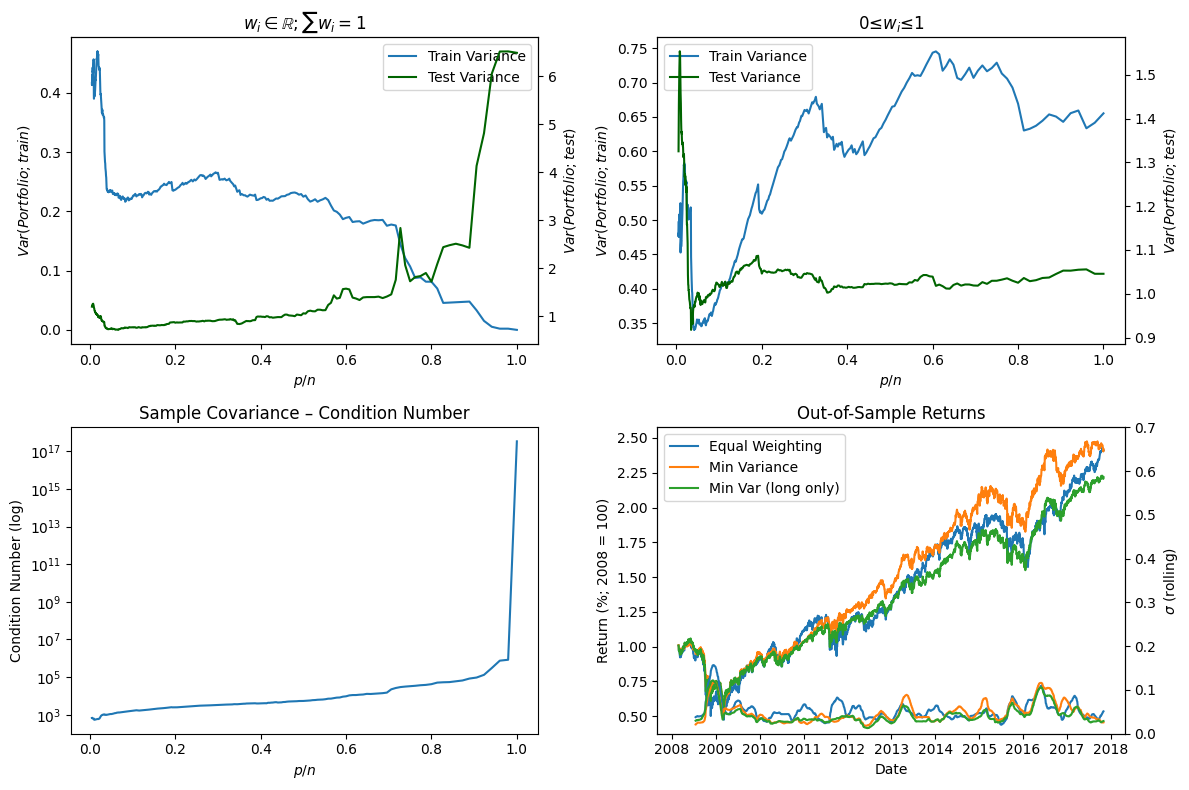

In [514]:
fig, axes = plt.subplots(2,2, tight_layout=True, figsize=(12,8))
axes[0,0].plot(res_df.index, res_df["train_var"], label="Train Variance")
axes02 = axes[0,0].twinx()
axes02.plot(res_df.index, res_df["test_var"], color="darkgreen", label="Test Variance")

axes[0,1].plot(res_df_ns.index, res_df_ns["train_var"])
axes12 = axes[0,1].twinx()
axes12.plot(res_df_ns.index, res_df_ns["test_var"], color="darkgreen")

labels = [x + y for x,y in zip(axes[0,0].get_legend_handles_labels(), axes02.get_legend_handles_labels())]
axes[0,0].legend(labels[0], labels[1])
axes[0,1].legend(labels[0], labels[1])
axes[0,0].set_title("$w_i \in \mathbb{R}; \sum w_i=1$")
axes[0,1].set_title("$0 ≤ w_i ≤ 1$")
[axes[0,i].set_xlabel("$p/n$") for i in range(2)]
[axes[0,i].set_ylabel("$Var(Portfolio; train)$") for i in range(2)]
[axes.set_ylabel("$Var(Portfolio; test)$") for axes in [axes02,axes12]]

cond_df = pd.DataFrame(cond_arr, columns=["p/n", "Condition Number"])
axes[1,0].plot(cond_df["p/n"], cond_df["Condition Number"])
axes[1,0].set_xlabel("$p/n$")
axes[1,0].set_ylabel("Condition Number (log)")
axes[1,0].set_yscale("log")
axes[1,0].set_title("Sample Covariance – Condition Number")

def return_transform(x, w): return (((x*w).sum(axis=1)+100)/100).cumprod()
w_star = min_var(df_train)
w_star_ns = min_var_no_shorts(df_train)
avg = np.full(48, 1/48)

axes[1,1].plot(return_transform(df_test, avg), label="Equal Weighting")
axes[1,1].plot(return_transform(df_test, w_star), label="Min Variance")
axes[1,1].plot(return_transform(df_test, w_star_ns), label="Min Var (long only)")
axes[1,1].set_xlabel("Date")
axes[1,1].set_ylabel("Return (%; 2008 = 100)")
axes[1,1].set_title("Out-of-Sample Returns")
axes2 = axes[1,1].twinx()
axes2.set_ylim([0,0.7])
axes2.plot(return_transform(df_test, avg).rolling(100).std())
axes2.plot(return_transform(df_test, w_star).rolling(100).std())
axes2.plot(return_transform(df_test, w_star_ns).rolling(100).std())
axes2.set_ylabel("$\sigma$ (rolling)")
axes[1,1].legend()

plt.savefig("unregularised_variance.png", dpi=200)


In [517]:
w_star = min_var(df_train)
w_star_ns = min_var_no_shorts(df_train)
avg = np.full(48, 1/48)

ret, var = calc_var_ret(w_star, df_test)
print((ret-0.02)/var, var)
ret, var = calc_var_ret(w_star_ns, df_test)
print((ret-0.02)/var, var)
ret, var = calc_var_ret(avg, df_test)
print((ret-0.02)/var, var)

     pcost       dcost       gap    pres   dres
 0:  2.4500e-01 -8.3410e-01  6e+01  7e+00  8e+00
 1:  3.0468e-01 -7.4275e-01  2e+00  2e-01  2e-01
 2:  3.3210e-01  1.8367e-02  3e-01  2e-16  2e-15
 3:  2.7210e-01  1.7178e-01  1e-01  2e-16  9e-16
 4:  2.5212e-01  2.2729e-01  2e-02  1e-16  6e-16
 5:  2.4282e-01  2.3867e-01  4e-03  1e-16  7e-16
 6:  2.4015e-01  2.3993e-01  2e-04  8e-17  6e-16
 7:  2.3998e-01  2.3997e-01  4e-06  2e-16  6e-16
 8:  2.3997e-01  2.3997e-01  4e-08  2e-16  6e-16
Optimal solution found.
2.0022210587739133 1.1983682852124193
1.6588124735327796 1.325506036620052
1.2388008070136547 1.9295973687340926


In [ ]:
# Condition number plot.
# Variance of the weights... Could use those spot plots?

## Regularisation

In [324]:
kf = KFold(n_splits=5)
folds = [fold.max() for _, fold in kf.split(df_train)]

### Ridge

$$\min_w(w'Cw + \lambda\sum_iw_i^2)\\
s.t. \hspace{0.5em}\sum_iw_i = 1\\
 w_i^* = \frac{\sum_j\left((C+\lambda 1)^{-1}\right)_{ij}}{\sum_k\sum_j\left( (C+\lambda 1)^{-1}\right)_{kj}}$$

In [21]:
def min_var_ridge(arr, lam):
    C = pd.DataFrame(arr).cov() + lam*np.eye(arr.shape[1])
    C_lam_inv = np.linalg.inv(C)
    sum_over_j = np.sum(C_lam_inv, axis=1)
    sum_over_kj = np.sum(C_lam_inv)
    w_star = sum_over_j / sum_over_kj

    return w_star

cross_val_res = []
lam_range = np.linspace(0,2,100)

for i in range(len(folds)-1):
    w_star_reg_arr = [min_var_ridge(df_train.iloc[:folds[i]], lam) for lam in lam_range]
    var_rets = [calc_var_ret(df_train.iloc[folds[i]:folds[i+1]].to_numpy(), w_star)[1] for w_star in w_star_reg_arr]
    cross_val_res.append(var_rets)

cross_val_res_mean = np.array(cross_val_res).T.mean(axis=1)

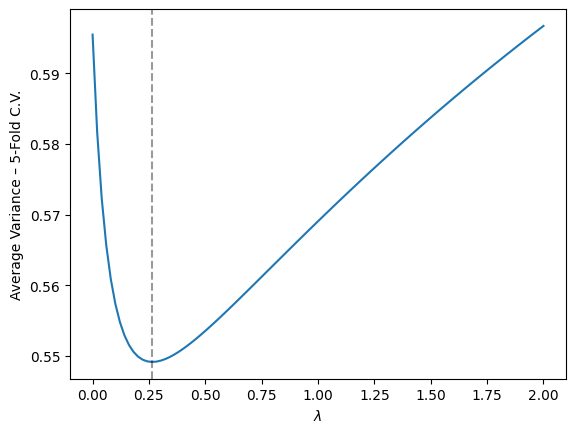

In [27]:
plt.plot(lam_range, cross_val_res_mean)
plt.ylabel("Average Variance – 5-Fold C.V.")
plt.xlabel("$\lambda$")
plt.axvline(lam_range[cross_val_res_mean.argmin()], color="black", linestyle="dashed", alpha=0.4)

In [507]:
res_rid = []
cond_arr_reg = []
optimal_lam = lam_range[cross_val_res_mean.argmin()]

for i in space:
    i_train = df_train[-i:]
    w_star_rid = min_var_ridge(i_train, lam=optimal_lam)
    cond_arr_reg.append([p/len(i_train), condition_num(i_train, lam=optimal_lam)])
    res_rid.append([p/len(i_train), *calc_var_ret(i_train, w_star_rid), *calc_var_ret(df_test, w_star_rid)])

res_df_rid = pd.DataFrame(res_rid, columns=["p/n", "train_ret", "train_var", "test_ret", "test_var"])
res_df_rid.set_index("p/n", drop=True, inplace=True)

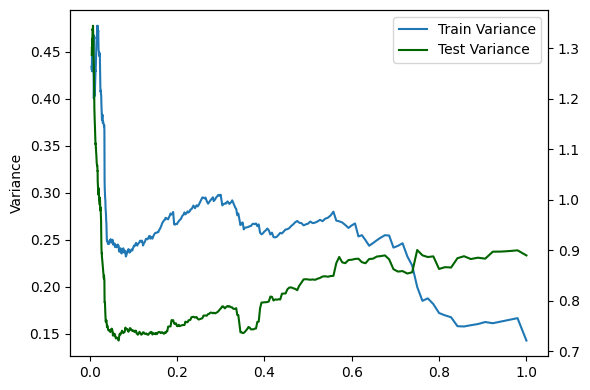

In [509]:
fig, axes = plt.subplots(tight_layout=True, figsize=(6,4))
axes.plot(res_df_rid.index, res_df_rid["train_var"], label="Train Variance")
axes02 = axes.twinx()
axes02.plot(res_df_rid.index, res_df_rid["test_var"], color="darkgreen", label="Test Variance")
axes.set_ylabel("Variance")
axes.set_xlabel("")
labels = [x + y for x,y in zip(axes.get_legend_handles_labels(), axes02.get_legend_handles_labels())]
plt.legend(labels[0], labels[1])
plt.show()

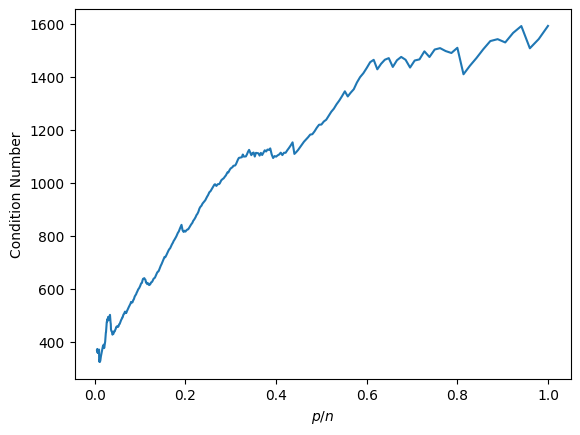

In [43]:
cond_reg_df = pd.DataFrame(cond_arr_reg, columns=["p/n", "Condition Number"])
plt.plot(cond_reg_df["p/n"], cond_reg_df["Condition Number"])
plt.xlabel("$p/n$")
plt.ylabel("Condition Number")
plt.show()

### Elastic Net Regularisation



In [154]:
from numpy.linalg import norm
from scipy.optimize import minimize

In [194]:
R = df_train.cov()
mu = df_train.mean(axis=0)

In [273]:
def james_stein(mu_s, data):
    C = data.cov()
    J = np.linalg.inv(C)
    ones = np.ones(shape=(len(C),))
    nu = np.minimum(mu_s.mean(), 0.0004)
    rho = np.minimum(1, (48-2)/(data.shape[0]*(mu_s - nu*ones).T@J@(mu_s - nu*ones)))
    mu_hat = (1 - rho)*mu_s - rho*nu*1
    return mu_hat

mu_js = james_stein(mu, df_train)

In [359]:
def min_w(d, b, lam, data):
    R = data.cov()
    mu = data.mean(axis=0)
    mu = james_stein(mu, data)

    def obj(w, d, b, R, mu, lam, beta=0.5):
        res = w.T@R@w - w.T@mu + 0.5*lam*np.sum(np.power(d - beta*w - b, 2))
        return res
    #np.random.uniform(size=(48,))
    return minimize(obj, x0=np.zeros(shape=(48,)), args=(d,b,R,mu,lam))

#w = min_w(d[0], b[:,0], df_train)["x"]

def shrink(x,gamma):
    return x/np.abs(x)*np.maximum(np.abs(x) - gamma, 0)

#shrink(beta*w[:,k] + b[:,k], 1/lam)

In [360]:
def split_bregman(df, lam):
    iters = 1000
    #lam = 3
    epsilon = 0.01
    beta = 0.7
    k = 0

    b = np.zeros((df.shape[1], iters))
    d = np.zeros((df.shape[1] ,iters))
    w = np.zeros((df.shape[1], iters))

    l2_norm = np.infty

    while l2_norm > epsilon:
        w[:,k+1] = min_w(d[:, k], b[:,k], lam, df)["x"]
        d[:,k+1] = shrink(beta*w[:,k+1] + b[:,k], 1/lam)
        b[:,k+1] = b[:,k] + beta*w[:,k+1] - d[:,k+1]
        l2_norm = np.sqrt(np.sum(np.power(w[:,k+1]-w[:,k],2)))
        k = k+1
        #print(k, l2_norm)

    w_star = w[:,k]
    return w_star/w_star.sum()

In [478]:
# Cross validation for optimal lambda.
cross_val_res_elastic = []
lam_range = np.linspace(0.5,10,80)

for i in range(len(folds)-1):
    w_star_reg_arr = [split_bregman(df_train.iloc[:folds[i]], lam) for lam in lam_range]
    var_rets = [calc_var_ret(df_train.iloc[folds[i]:folds[i+1]].to_numpy(), w_star) for w_star in w_star_reg_arr]
    cross_val_res_elastic.append(var_rets)

In [479]:
# Aggregate the data and analyse results.
data = pd.DataFrame()
for i in range(4):
    data = pd.concat([data, pd.DataFrame(np.array(cross_val_res_elastic)[i])], axis=1)
rets = data[0].mean(axis=1)
vars = data[1].mean(axis=1)
optimal_lam = lam_range[np.argmax(rets/vars)]
optimal_lam

7.955696202531645

In [518]:
# Test sharpe given CVd lambda.
w_star_sb = split_bregman(df_train, optimal_lam)
ret, var = calc_var_ret(df_test, w_star_sb)
(ret-0.02)/var

1.924938308895527

In [519]:
ret, var = calc_var_ret(df_test, w_star_rid)
(ret-0.02)/var

1.910553020137559

In [520]:
avg = np.full((48,), 1/48)
ret, var = calc_var_ret(df_test, avg)
(ret-0.02)/var

1.2388008070136547

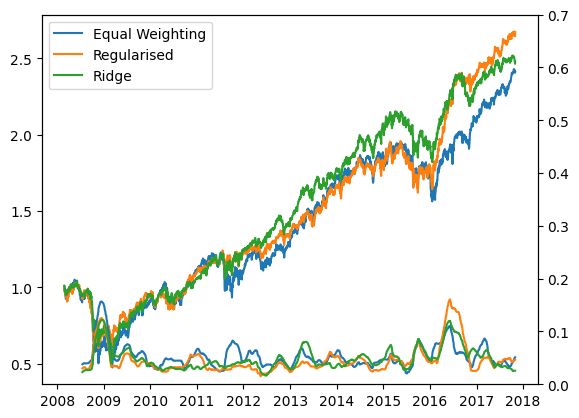

In [400]:
def return_transform(x, w): return (((x*w).sum(axis=1)+100)/100).cumprod()

fig, axes = plt.subplots()
axes.plot(return_transform(df_test, avg), label="Equal Weighting")
axes.plot(return_transform(df_test, w_star_sb), label="Elastic Net")
axes.plot(return_transform(df_test, w_star_rid), label="Ridge")
axes2 = axes.twinx()
axes2.set_ylim([0,0.7])
axes2.plot(return_transform(df_test, avg).rolling(100).std())
axes2.plot(return_transform(df_test, w_star_sb).rolling(100).std())
axes2.plot(return_transform(df_test, w_star_rid).rolling(100).std())
axes.legend()

# DO IN SAMPLE TRAIN BESIDES? GET TABLE GOING

Big Plot

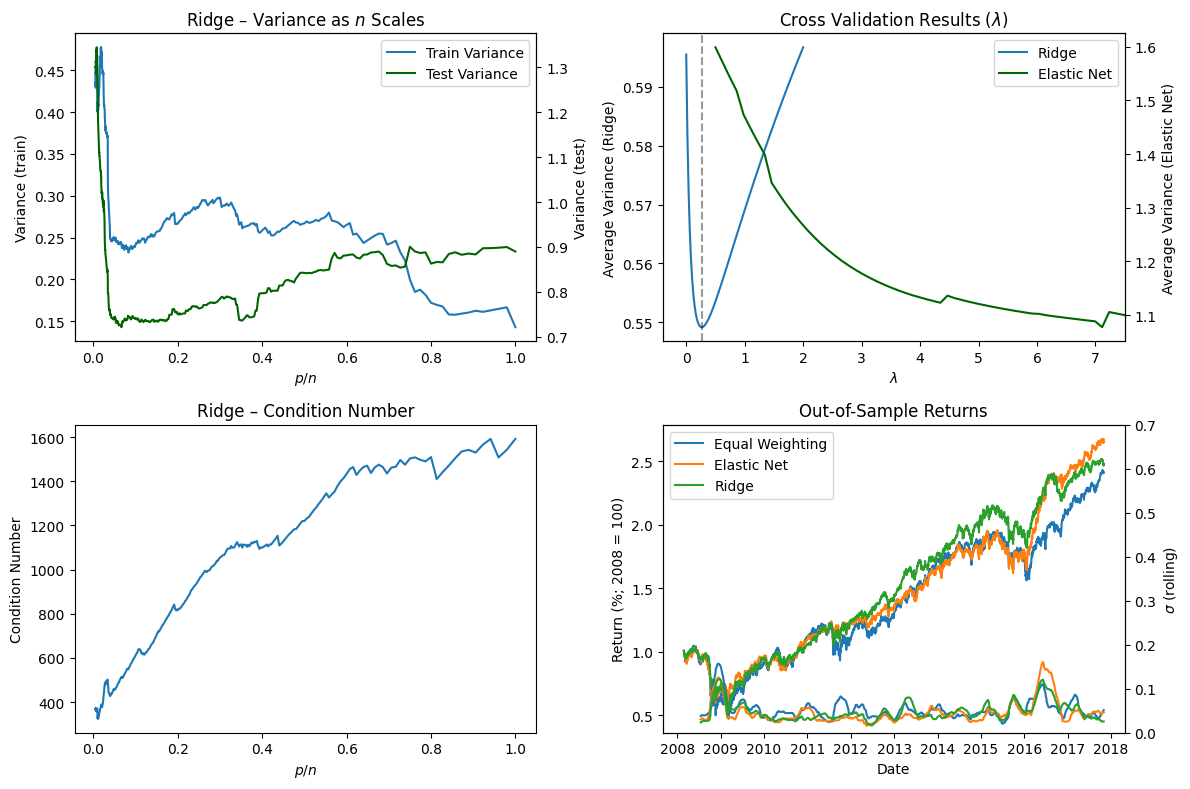

In [511]:
# NEED PLOTS OF BUY/HOLD VS this strat? Rolling port std on the bottom?
cross_val_res = []
lam_range = np.linspace(0, 2, 100)

for i in range(len(folds) - 1):
    w_star_reg_arr = [min_var_ridge(df_train.iloc[:folds[i]], lam) for lam in lam_range]
    var_rets = [calc_var_ret(df_train.iloc[folds[i]:folds[i + 1]].to_numpy(), w_star)[1] for w_star in w_star_reg_arr]
    cross_val_res.append(var_rets)

fig, axes = plt.subplots(2,2, figsize=(12,8), tight_layout=True)
axes[0,0].plot(res_df_rid.index, res_df_rid["train_var"], label="Train Variance")
axes02 = axes[0,0].twinx()
axes02.plot(res_df_rid.index, res_df_rid["test_var"], color="darkgreen", label="Test Variance")
axes02.set_ylabel("Variance (test)")
axes[0,0].set_ylabel("Variance (train)")
axes[0,0].set_xlabel("$p/n$")
labels = [x + y for x,y in zip(axes[0,0].get_legend_handles_labels(), axes02.get_legend_handles_labels())]
axes[0,0].legend(labels[0], labels[1])
axes[0,0].set_title("Ridge – Variance as $n$ Scales")

cross_val_res_mean = np.array(cross_val_res).T.mean(axis=1)
axes[0,1].plot(lam_range, cross_val_res_mean, label="Ridge")
axes[0,1].set_ylabel("Average Variance (Ridge)")
axes[0,1].set_xlabel("$\lambda$")
axes_lam_elastic = axes[0,1].twinx()
axes_lam_elastic.plot(np.linspace(0.5,10,80), vars, color="darkgreen", label="Elastic Net")
axes_lam_elastic.set_ylabel("Average Variance (Elastic Net)")
axes[0,1].set_xlim([-0.4,7.5])
axes[0,1].axvline(lam_range[cross_val_res_mean.argmin()], color="black", linestyle="dashed", alpha=0.4)
labels = [x + y for x,y in zip(axes[0,1].get_legend_handles_labels(), axes_lam_elastic.get_legend_handles_labels())]
axes[0,1].legend(labels[0], labels[1])
axes[0,1].set_title("Cross Validation Results ($\lambda$)")

cond_reg_df = pd.DataFrame(cond_arr_reg, columns=["p/n", "Condition Number"])
axes[1,0].plot(cond_reg_df["p/n"], cond_reg_df["Condition Number"])
axes[1,0].set_xlabel("$p/n$")
axes[1,0].set_ylabel("Condition Number")
axes[1,0].set_title("Ridge – Condition Number")

axes[1,1].plot(return_transform(df_test, avg), label="Equal Weighting")
axes[1,1].plot(return_transform(df_test, w_star_sb), label="Elastic Net")
axes[1,1].plot(return_transform(df_test, w_star_rid), label="Ridge")
axes2 = axes[1,1].twinx()
axes2.set_ylim([0,0.7])
axes2.plot(return_transform(df_test, avg).rolling(100).std())
axes2.plot(return_transform(df_test, w_star_sb).rolling(100).std())
axes2.plot(return_transform(df_test, w_star_rid).rolling(100).std())
axes2.set_ylabel("$\sigma$ (rolling)")
axes[1,1].legend()
axes[1,1].set_xlabel("Date")
axes[1,1].set_ylabel("Return (%; 2008 = 100)")
axes[1,1].set_title("Out-of-Sample Returns")

plt.savefig("results_regularisation.png", dpi=200)

In [513]:
df_test

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-26,-0.85,0.62,1.20,0.30,0.15,0.08,0.21,1.75,1.18,2.21,...,0.48,1.32,0.49,1.52,1.58,-0.08,0.99,0.95,0.18,-0.54
2008-02-27,-1.09,-0.30,-0.34,0.36,0.04,-1.73,-0.31,-0.97,-0.20,-0.36,...,-0.17,-1.29,0.07,-0.27,-1.28,0.61,0.60,-0.34,1.42,0.40
2008-02-28,-0.61,-0.15,-0.92,-0.34,-0.95,-1.76,-2.93,-2.83,-0.66,-1.76,...,-1.18,-1.50,-1.15,-2.10,-1.73,-3.01,-2.46,-2.22,-2.67,-0.53
2008-02-29,-2.35,-1.77,-2.91,-1.95,-0.94,-3.15,-2.19,-2.35,-1.78,-3.61,...,-1.57,-2.53,-2.59,-2.80,-1.68,-3.91,-3.54,-3.18,-3.94,-1.53
2008-03-03,2.21,0.67,0.29,0.70,-0.20,0.41,-1.03,-0.78,0.52,-0.02,...,-0.30,0.35,0.20,0.58,-0.92,-1.44,-0.50,-0.37,-1.44,-0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-25,-0.19,-0.16,-0.62,-0.59,-1.06,0.72,-0.92,-0.34,-0.27,1.12,...,-0.56,-1.73,-0.45,0.00,-0.68,-0.20,-0.02,-1.24,-0.81,-0.79
2017-10-26,0.01,-0.20,0.45,0.26,1.30,0.37,0.17,0.18,0.40,1.45,...,0.29,0.91,-0.48,0.03,1.08,0.76,0.99,1.06,0.70,0.04
2017-10-27,0.09,0.12,-0.32,-0.36,-1.10,-1.20,1.04,-0.54,-0.59,-0.57,...,-0.09,-0.26,-1.46,2.79,0.19,0.29,0.32,-0.04,-0.12,-0.55
